In [11]:
import pandas as pd
import os
import cv2  
from tqdm import tqdm
import matplotlib.pyplot as plt

from collections import defaultdict

In [10]:
def show_image(images,name,row,col,size1=15,size2=15):
    n = len(images)
    plt.subplots(figsize=(15, 15))

    for i in range(n):
        plt.subplot(row,col,i+1)
        plt.title(name[i])
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')   
    plt.show()

In [2]:
train_path = "data/train"
test_path = "data/test"

In [3]:
train = os.listdir(train_path)
test = os.listdir(test_path)

In [4]:
train_image = [cv2.cvtColor(cv2.imread(os.path.join(train_path, image)), cv2.COLOR_BGR2RGB)  for image in train ]

In [5]:
test_image = [cv2.cvtColor(cv2.imread(os.path.join(test_path, image)), cv2.COLOR_BGR2RGB)  for image in test ]

In [8]:
blank = []
for i in range(len(des_test_orb)):
    try:
        len(des_test_orb[i])
    except:
        blank.append(i)

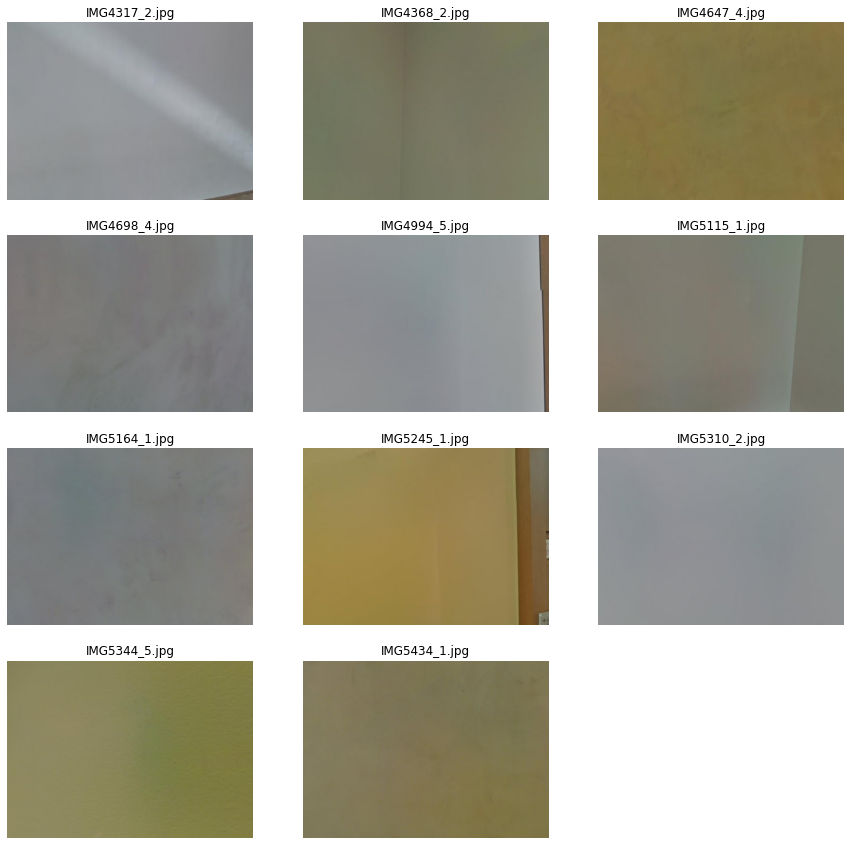

In [13]:
show_image(list(map(test_image.__getitem__,blank)),list(map(test.__getitem__,blank)),4,3)

# ORB

In [6]:
orb = cv2.ORB_create()

In [9]:
kp_train_orb = []
des_trian_orb = []
for image in tqdm(train_image):
    kp, des = orb.detectAndCompute(image,None)
    kp_train_orb.append(kp)
    des_trian_orb.append(des)

100%|██████████| 7500/7500 [00:58<00:00, 127.94it/s]


In [20]:
summ = 0
for i in range(len(des_trian_orb)):
    try:
        summ += len(des_trian_orb[i])
    except:
        summ += 0

print(summ / 7500)

470.9024


In [7]:
kp_test_orb = []
des_test_orb = []
for image in tqdm(test_image):
    kp, des = orb.detectAndCompute(image,None)
    kp_test_orb.append(kp)
    des_test_orb.append(des)

100%|██████████| 1200/1200 [00:09<00:00, 120.85it/s]


# SIFT

In [14]:
sift = cv2.SIFT_create() 

In [15]:
kp_train_sift = []
des_trian_sift = []
for image in tqdm(train_image):
    kp, des = sift.detectAndCompute(image,None)
    kp_train_sift.append(kp)
    des_trian_sift.append(des)

100%|██████████| 7500/7500 [06:41<00:00, 18.70it/s]


In [8]:
summ = 0
for i in range(len(des_trian_sift)):
    try:
        summ += len(des_trian_sift[i])
    except:
        summ += 0

print(summ / 7500)

1189.7724


In [16]:
kp_test_sift = []
des_test_sift = []
for image in tqdm(test_image):
    kp, des = sift.detectAndCompute(image,None)
    kp_test_sift.append(kp)
    des_test_sift.append(des)

100%|██████████| 1200/1200 [01:04<00:00, 18.74it/s]


In [17]:
index_params = dict(algorithm = 1, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [18]:
for i in range(len(des_trian_sift)):
    flann.add([des_trian_sift[i]])

In [19]:
flann.train()

In [20]:
print(len(flann.getTrainDescriptors()))

7500


# FLANN Match

In [ ]:
result = {}
for i in tqdm(range(len(test))):
    matches = flann.match(des_test_sift[i])
    matches_dict = defaultdict(lambda : 0)
    for f in matches:
        matches_dict[f.imgIdx]+=1
    temp = sorted(matches_dict.items(),key=lambda x:x[1],reverse=True)
    result[test[i]] = temp

In [ ]:
result_index = []
for key in result.keys():
    try:
        result_index.append(result[key][0][0])
    # if the detector is None, the FLANN can not find any match item, return None
    except:
        result_index.append(None)

In [ ]:
train_data = pd.read_csv("data/train.csv")

In [ ]:
cnn = pd.read_csv("result/CNN_baseline.csv")

In [ ]:
# Using the baseline result to replace the None
x_coor = []
y_coor = []
for i in range(len(result_index)):
    index = result_index[i]
    if index:
        x_coor.append(train_data.iloc[index][["x"]][0])
        y_coor.append(train_data.iloc[index][["y"]][0])
    else:
        x_coor.append(cnn.iloc[i][["x"]][0])
        y_coor.append(cnn.iloc[i][["y"]][0])


In [ ]:
submit = pd.read_csv("data/imagenames.csv")
submit["x"] = x_coor
submit["y"] = y_coor

In [ ]:
submit.to_csv("result/sift_match.csv",index = False)

# FLANN KNN_match

In [32]:
result_knn = {}
for i in tqdm(range(len(test))):
    knn_matches = flann.knnMatch(des_test_sift[i],k=2)
    matches_dict = defaultdict(lambda : 0)
    for m,n in knn_matches:
        if m.distance < 0.8 *n.distance: 
            matches_dict[m.imgIdx]+=1
    temp = sorted(matches_dict.items(),key=lambda x:x[1],reverse=True)
    result_knn[test[i]] = temp

100%|██████████| 1200/1200 [10:48<00:00,  1.85it/s]


In [33]:
result_index = []
for key in result_knn.keys():
    try:
        result_index.append(result_knn[key][0][0])
    except:
        result_index.append(None)

In [34]:
train_data = pd.read_csv("data/train.csv")

In [25]:
cnn = pd.read_csv("result/CNN_baseline.csv")

In [35]:
x_coor = []
y_coor = []
for i in range(len(result_index)):
    index = result_index[i]
    if index:
        x_coor.append(train_data.iloc[index][["x"]][0])
        y_coor.append(train_data.iloc[index][["y"]][0])
    else:
        x_coor.append(cnn.iloc[i][["x"]][0])
        y_coor.append(cnn.iloc[i][["y"]][0])

In [36]:
x_coor = []
y_coor = []
for i in range(len(result_index)):
    index = result_index[i]
    if index:
        x_coor.append(train_data.iloc[index][["x"]][0])
        y_coor.append(train_data.iloc[index][["y"]][0])
    else:
        x_coor.append(train_data["x"].mean())
        y_coor.append(train_data["y"].mean())

In [31]:
submit.to_csv("result/sift_KNNmatch_no_CNN_0.8.csv",index = False)

In [29]:
submit = pd.read_csv("data/imagenames.csv")
submit["x"] = x_coor
submit["y"] = y_coor

In [40]:
submit.to_csv("result/sift_KNNmatch0.6.csv",index = False)